In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from torch.autograd import Variable
from torchaudio.transforms import MelSpectrogram

import librosa as lib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import copy
import csv
import math
import statistics
import random
import time
import torchaudio
from torch.utils.data import DataLoader, TensorDataset
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm
import tensorflow as tf
import keras
from sklearn import preprocessing
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

In [20]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
train_inputs = pd.read_csv('/content/drive/My Drive/SeniorDesignData/train_X.csv')
train_labels = pd.read_csv('/content/drive/My Drive/SeniorDesignData/train_y.csv')
test_inputs = pd.read_csv('/content/drive/My Drive/SeniorDesignData/test_X.csv')
test_labels = pd.read_csv('/content/drive/My Drive/SeniorDesignData/test_y.csv')

In [ ]:
from scipy.signal import resample_poly

def downsample_dataframe(data, original_rate, target_rate):
    """
    Downsample audio data in a DataFrame from original_rate to target_rate.

    Parameters:
    - data (pd.DataFrame): DataFrame with audio data (each row corresponds to 1 second).
    - original_rate (int): Original sampling rate of the data.
    - target_rate (int): Target sampling rate.

    Returns:
    - pd.DataFrame: DataFrame with downsampled audio data.
    """

    # Calculate the resampling factor
    downsample_factor = original_rate // target_rate

    # Number of samples in the original data
    original_samples = data.shape[1]

    # Number of samples in the downsampled data
    target_samples = original_samples // downsample_factor

    # Create an empty DataFrame for the downsampled data
    downsampled_data = pd.DataFrame(index=data.index, columns=range(target_samples))

    # Resample each row of the original data
    for index, row in data.iterrows():
        downsampled_data.loc[index] = resample_poly(row, up=1, down=downsample_factor)

    return downsampled_data

In [ ]:
# Example usage:
# Assuming 'your_data' is your original DataFrame with audio data sampled at 16000 Hz
# Replace this with your actual DataFrame and sampling rates
original_rate = 16000
target_rate = 4000
downsampled_data = downsample_dataframe(your_data, original_rate, target_rate)

In [23]:
def dataframe_to_melspectrograms(df, sample_rate=16000, ref_value=1.0, amin=1e-10, top_db=80.0):
    """
    Transforms a DataFrame of audio samples into Mel Spectrograms.

    Parameters:
    df (pd.DataFrame): DataFrame where each row is an audio sample.
    sample_rate (int): The sampling rate of the audio samples.

    Returns:
    A list or DataFrame of Mel Spectrograms.
    """
    mel_spectrograms = []

    # Define the MelSpectrogram transform
    mel_transform = MelSpectrogram(sample_rate=sample_rate)

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Convert row to tensor
        waveform = row.to_numpy()
        waveform_tensor = torch.tensor([waveform], dtype=torch.float32)

        # Apply MelSpectrogram transform
        mel_spec = mel_transform(waveform_tensor)
        mel_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        # Append the result to the list
        mel_spectrograms.append(mel_db)

    return mel_spectrograms

In [24]:
train_mel_inputs = dataframe_to_melspectrograms(train_inputs)
test_mel_inputs = dataframe_to_melspectrograms(test_inputs)

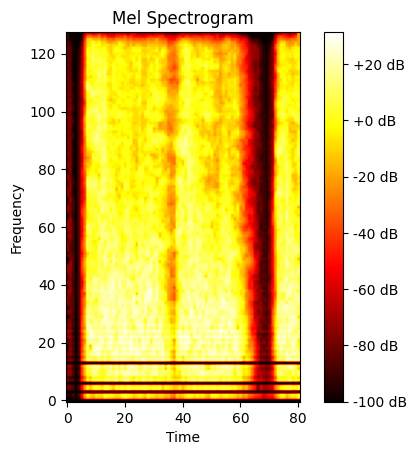

In [ ]:
mel_spec_db = test_mel_inputs[127]
plt.imshow(mel_spec_db.squeeze().numpy(), cmap='hot', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [25]:
def create_model(input_shape, learning_rate):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
print(X_train[0])

tensor([[[-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
          -100.0000],
         [ -46.5192,  -51.4617,  -54.5353,  ...,  -60.6167,  -73.6300,
           -68.4146],
         [ -39.2080,  -44.1504,  -47.2240,  ...,  -53.3054,  -66.3187,
           -61.1033],
         ...,
         [ -49.9639,  -58.5705,  -62.3295,  ...,  -77.9368,  -76.8857,
           -78.2267],
         [ -56.4835,  -76.8666,  -80.4860,  ...,  -91.8437,  -92.0092,
           -82.7305],
         [ -56.5616,  -93.4333, -100.0000,  ..., -100.0000, -100.0000,
           -85.0954]]])


In [28]:
input_shape = (128, 81, 1)

# Define your different learning rates and batch sizes
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128, 256]

# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle = True)

X_data = np.array(train_mel_inputs)
y_data = train_labels.to_numpy().flatten()

In [29]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

losses = []
accuracies = []

# Loop through each fold
for fold_idx, (train_index, test_index) in enumerate(skf.split(X_data, y_data)):
    X_train, X_val = X_data[train_index], X_data[test_index]
    y_train, y_val = y_data[train_index], y_data[test_index]

    # Convert input data to NumPy arrays
    #X_train1 = np.array([x.numpy() for x in X_train])
    #X_val1 = np.array([x.numpy() for x in X_val])
    X_train1 = np.array(X_train)
    X_val1 = np.array(X_val)
    y_train = np.array(y_train)
    y_val = np.array(y_val)

    X_train1 = np.transpose(X_train1, (0, 2, 3, 1))
    X_val1 = np.transpose(X_val1, (0, 2, 3, 1))

    fold_losses = []
    fold_accuracies = []

    # Loop through each combination of learning rate and batch size
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # Create the model
            model = create_model(input_shape=(128, 81, 1), learning_rate=lr)

            # Train the model
            history = model.fit(X_train1, y_train, batch_size=batch_size, epochs=5, verbose=1)
            fold_losses.append(history.history['loss'])

            # Evaluate the model
            loss, accuracy = model.evaluate(X_val1, y_val)
            fold_accuracies.append(accuracy)
            print(f'Learning Rate: {lr}, Batch Size: {batch_size}, Test Accuracy: {accuracy}')
    losses.append(fold_losses)
    accuracies.append(fold_accuracies)


Epoch 1/5
319/319 [==============================] - 31s 96ms/step - loss: 1.7599 - accuracy: 0.9343
Epoch 2/5
319/319 [==============================] - 28s 89ms/step - loss: 0.1527 - accuracy: 0.9573
Epoch 3/5
319/319 [==============================] - 29s 91ms/step - loss: 0.1364 - accuracy: 0.9614
Epoch 4/5
319/319 [==============================] - 30s 95ms/step - loss: 0.1259 - accuracy: 0.9626
Epoch 5/5
80/80 [==============================] - 2s 19ms/step - loss: 0.1573 - accuracy: 0.9580
Learning Rate: 0.001, Batch Size: 32, Test Accuracy: 0.9580392241477966
Epoch 1/5
160/160 [==============================] - 27s 162ms/step - loss: 2.7976 - accuracy: 0.9227
Epoch 2/5
160/160 [==============================] - 25s 159ms/step - loss: 0.1415 - accuracy: 0.9571
Epoch 3/5
160/160 [==============================] - 23s 145ms/step - loss: 0.1251 - accuracy: 0.9617
Epoch 4/5
160/160 [==============================] - 23s 145ms/step - loss: 0.1155 - accuracy: 0.9644
Epoch 5/5
80/80 [=

KeyboardInterrupt: 

In [ ]:
# Plot loss curves for each model instance within each fold
for fold_idx, fold_losses in enumerate(losses):
    plt.figure(figsize=(10, 6))
    plt.title(f'Loss Curves - Fold {fold_idx + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    for idx, loss_curve in enumerate(fold_losses):
        plt.plot(loss_curve, label=f'Model {idx + 1}')
    plt.legend()
    plt.show()

In [ ]:
# Plotting accuracies for each fold
for fold_idx, fold_accuracies in enumerate(accuracies):
    plt.plot(range(len(fold_accuracies)), fold_accuracies, label=f'Fold {fold_idx + 1}')

plt.xlabel('Model Index')
plt.ylabel('Accuracy')
plt.title('Accuracy for each model in Cross-Validation')
plt.legend()
plt.show()

In [ ]:
average_losses = np.mean(losses, axis=0).reshape(len(learning_rates), len(batch_sizes))
plt.imshow(average_losses, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel('Batch Size')
plt.ylabel('Learning Rate')
plt.title('Average Loss for each LR and Batch Size')
plt.xticks(ticks=range(len(batch_sizes)), labels=batch_sizes)
plt.yticks(ticks=range(len(learning_rates)), labels=learning_rates)
plt.show()

In [40]:
# Train the best model on the entire dataset
lr_best = 0.001
bs_best = 128
X = np.array(train_mel_inputs)
X = X.reshape(-1, 128, 81, 1)
y = train_labels.to_numpy().flatten()

from keras.callbacks import ModelCheckpoint, EarlyStopping


# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

best_model = create_model(input_shape=(128, 81, 1), learning_rate=lr_best)

# Fit the model with callbacks
history = best_model.fit(X, y, epochs=20, batch_size=bs_best, validation_split=0.2, callbacks=[checkpoint, early_stopping], verbose=1)


Epoch 1/20
80/80 [==============================] - ETA: 0s - loss: 9.0337 - accuracy: 0.8831
Epoch 1: val_accuracy improved from -inf to 0.94275, saving model to best_model.h5
80/80 [==============================] - 25s 301ms/step - loss: 9.0337 - accuracy: 0.8831 - val_loss: 0.3139 - val_accuracy: 0.9427
Epoch 2/20
80/80 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9534
Epoch 2: val_accuracy improved from 0.94275 to 0.96235, saving model to best_model.h5
80/80 [==============================] - 24s 306ms/step - loss: 0.1490 - accuracy: 0.9534 - val_loss: 0.1923 - val_accuracy: 0.9624
Epoch 3/20
80/80 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9555
Epoch 3: val_accuracy did not improve from 0.96235
80/80 [==============================] - 22s 278ms/step - loss: 0.1391 - accuracy: 0.9555 - val_loss: 0.2931 - val_accuracy: 0.9435
Epoch 4/20
80/80 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9586
Epoch 4:

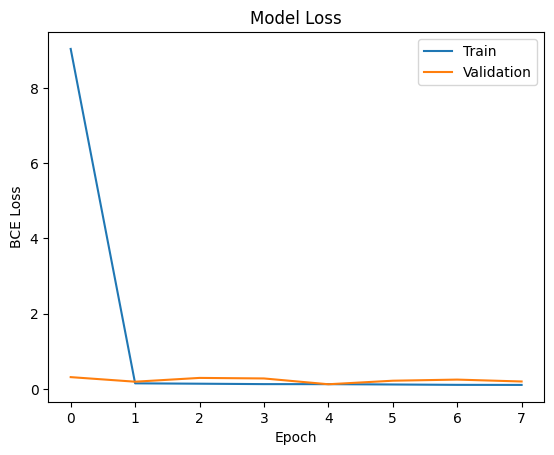

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('BCE Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [42]:
from keras.models import load_model
best_model = load_model('best_model.h5')

In [ ]:
def model_builder(learning_rate):
    def wrapper(input_shape):
        return create_model(input_shape, learning_rate)
    return wrapper

In [ ]:
X = np.array(train_mel_inputs)  # Mel spectrograms data
y = train_labels.values  # Binary labels

<ipython-input-60-916b803a5e06>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.array(train_mel_inputs)  # Mel spectrograms data
<ipython-input-60-916b803a5e06>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(train_mel_inputs)  # Mel spectrograms data


In [ ]:
# Define the number of folds for cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

In [ ]:
# Define the input shape
input_shape = (128, 81, 1)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'batch_size': [32, 64, 96, 128],  # Adjust batch sizes as needed
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]  # Adjust learning rates as needed
}

# Wrap the Keras model with KerasClassifier
keras_model = KerasClassifier(build_fn=model_builder, verbose=0)

In [ ]:
# Initialize lists to store performance metrics
accuracy_scores = []

# Loop through the folds
for fold_index, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    print(f"Fold {fold_index}/{num_folds}")

    # Split data into training and validation sets for this fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Perform GridSearchCV to find the best batch size and learning rate
    grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_batch_size = grid_search.best_params_['batch_size']
    best_learning_rate = grid_search.best_params_['learning_rate']
    print(f"Best Batch Size: {best_batch_size}, Best Learning Rate: {best_learning_rate}")

    # Create the best model with the best hyperparameters
    model = create_model(input_shape, learning_rate=best_learning_rate)

    # Train the model on this fold's training data with the best hyperparameters
    model.fit(X_train, y_train, epochs=10, batch_size=best_batch_size, verbose=1)

    # Evaluate the model on this fold's validation data
    _, accuracy = model.evaluate(X_val, y_val, verbose=0)
    accuracy_scores.append(accuracy)

    # Print validation accuracy for this fold
    print(f"Validation Accuracy: {accuracy}")

# Calculate and print average accuracy across all folds
avg_accuracy = np.mean(accuracy_scores)
print(f"\nAverage Accuracy: {avg_accuracy}")

Fold 1/5
Fitting 2 folds for each of 20 candidates, totalling 40 fits


ValueError: Invalid parameter learning_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(learning_rate=0.001)`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
# Get the best estimator (model with the best hyperparameters) from GridSearchCV
best_model = grid_search.best_estimator_

In [ ]:
# Train the best model on the entire dataset
best_model.fit(X, y, epochs=10, batch_size=best_batch_size, verbose=1)